<a href="https://colab.research.google.com/github/sophiascarano/COVID-19_wildfire_CA_amenity_avoidance_app/blob/main/messy_drafts/torch_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue May 18 02:34:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Loading libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from statistics import mean
from torch.autograd import Variable
import time
from PIL import Image
import random
from skimage import io, transform
from collections import OrderedDict
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch import nn

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from matplotlib import pyplot as plt
from skimage import io, transform

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
csv_path =  '/content/drive/My Drive/Colab_Notebooks/brain_tumor/data/lgg-mri-segmentation/kaggle_3m/data.csv'
data_folder = '/content/drive/My Drive/Colab_Notebooks/brain_tumor/data/lgg-mri-segmentation/kaggle_3m/'
eg_path = '/content/drive/My Drive/Colab_Notebooks/brain_tumor/data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8113_19930809'
eg_img = '/content/drive/My Drive/Colab_Notebooks/brain_tumor/data/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_10.tif'
eg_mask = '/content/drive/My Drive/Colab_Notebooks/brain_tumor/data/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_10_mask.tif'

In [ ]:
class Brain_data(Dataset):
    def __init__(self,path):
        self.path = path
        self.patients = [file for file in os.listdir(path) if file not in ['data.csv','README.md']]
        self.masks,self.images = [],[]

        for patient in self.patients:
            for file in os.listdir(os.path.join(self.path,patient)):
                if 'mask' in file.split('.')[0].split('_'):
                    self.masks.append(os.path.join(self.path,patient,file))
                else: 
                    self.images.append(os.path.join(self.path,patient,file)) 
          
        self.images = sorted(self.images)
        self.masks = sorted(self.masks)
        
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        image = self.images[idx]
        mask = self.masks[idx]
        image = io.imread(image)
        image = transform.resize(image,(256,256))
        image = image / 255
        image = image.transpose((2, 0, 1))
        
        
        mask = io.imread(mask)
        mask = transform.resize(mask,(256,256))
        mask = mask / 255
        mask = np.expand_dims(mask,axis=-1).transpose((2, 0, 1))

        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)
        
        return (image,mask)

In [ ]:
data = Brain_data(data_folder)
print('Length of dataset is {}'. format(data.__len__()))
print('sample data: ')
data.__getitem__(0)

Length of dataset is 3929
sample data: 


(tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 6.5563e-19, 1.5379e-05,  ..., 1.5379e-05,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 5.5903e-32, 1.9669e-18,  ..., 1.5379e-05,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 6.5563e-19,  ..., 1.3113e-18,
           0.0000e+00, 0.0000e+00]],
 
         [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [4.6136e-05, 6.1515e-05, 6.1515e-05,  ..., 9.227

In [ ]:
# checking shape of data
for img,msk in data:
      print(img.shape)
      print(msk.shape)
      break

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


In [ ]:
# splitting to trainset and validation set

trainset, valset = random_split(data, [3600, 329])

train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=10,shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=valset, batch_size=10)

In [ ]:
# converting tensor to image
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255)
    return image

def mask_convert(mask):
    mask = mask.clone().cpu().detach().numpy()
    return np.squeeze(mask)

def plot_img(no_):
    iter_ = iter(train_loader)
    images,masks = next(iter_)
    # images = images.to(device)
    # masks = masks.to(device)
    plt.figure(figsize=(20,10))
    for idx in range(0,no_):
         image = image_convert(images[idx])
         plt.subplot(2,no_,idx+1)
         plt.imshow(image)
    for idx in range(0,no_):
         mask = mask_convert(masks[idx])
         plt.subplot(2,no_,idx+no_+1)
         plt.imshow(mask,cmap='gray')
    plt.show()

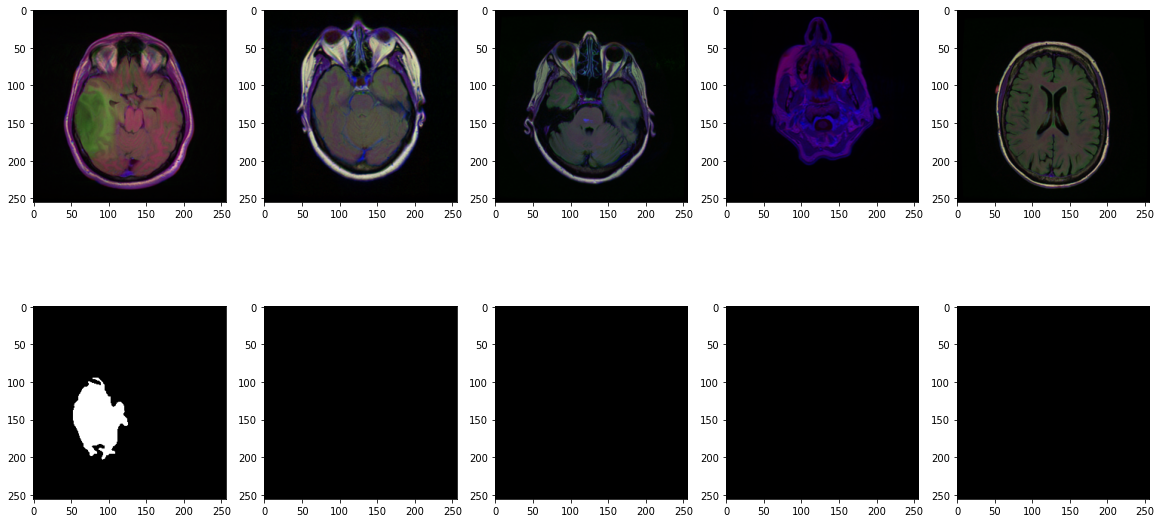

In [ ]:
plot_img(5)

# conv block

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=(3,3),padding=1):
        super(ConvBlock,self).__init__()
        self.conv = nn.Conv2d(in_channels,out_channels,kernel_size,padding=padding,bias=False)
        self.batchnorm = nn.BatchNorm2d(out_channels,eps=1e-4)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x

#kinet architecture

In [ ]:
class StackEncoderK(nn.Module):
    def __init__(self,channel1,channel2,kernel_size=(3,3),padding=1):
        # def __init__(self,big_channel,channel1,channel2,kernel_size=(3,3),padding=1):
        super(StackEncoderK,self).__init__()
        self.block = nn.Sequential(
            ConvBlock(channel1,channel2,kernel_size,padding),
        )
        
    def forward(self,x):
        x_conv = self.block(x) 
        _, channels, height, width = x_conv.size() 
        x_upsampled = F.upsample(x_conv, size=(height*2, width*2), mode='bilinear')
        return x_conv, x_upsampled
     
        
class StackDecoderK(nn.Module):
    def __init__(self,big_channel,channel1,channel2,kernel_size=(3,3),padding=1):
      super(StackDecoderK,self).__init__()
      self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
      self.block = nn.Sequential(
          ConvBlock(channel1+big_channel,channel2,kernel_size,padding), 
      )
        
    def forward(self,x,down_tensor):
      # big_out = self.block(x)
      # poolout = self.maxpool(big_out)
      # return big_out,poolout
      _, channels, height, width = down_tensor.size() 
      x = self.block(x)
      x = self.maxpool(x)
      x = torch.cat([x, down_tensor], 1)
      return x

class StackEncoderU(nn.Module):
    def __init__(self,channel1,channel2,kernel_size=(3,3),padding=1):
        super(StackEncoderU,self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.block = nn.Sequential(
            ConvBlock(channel1,channel2,kernel_size,padding),
            # ConvBlock(channel2,channel2,kernel_size,padding),     
        )
        
    def forward(self,x):
        big_out = self.block(x)
        poolout = self.maxpool(big_out)
        return big_out,poolout
     
        
class StackDecoderU(nn.Module):
    def __init__(self,big_channel,channel1,channel2,kernel_size=(3,3),padding=1):
        super(StackDecoderU,self).__init__()
        self.block = nn.Sequential(
            ConvBlock(channel1+big_channel,channel2,kernel_size,padding),
        )
        
    def forward(self,x,down_tensor):
        _, channels, height, width = down_tensor.size()  
        x = F.upsample(x, size=(height, width), mode='bilinear')
        x = torch.cat([x, down_tensor], 1) 
        x = self.block(x)
        return x

In [ ]:
class ComboStep(nn.Module):
  def __init__(self, big_channel, channel1, channel2, kernel_size=(3,3),padding=1):
    super(ComboStep, self).__init__()
    self.block = nn.Sequential(
        ConvBlock(channel1+big_channel, channel2,kernel_size,padding)
    )
  def forward(self,x, down_tensor):
    x = torch.cat([x, down_tensor], 1) 
    x = self.block(x)
    return x

In [ ]:
class KiUNet(nn.Module):
    def __init__(self,input_shape):
      super(KiUNet,self).__init__()

      self.block = nn.Sequential(
            ConvBlock(64,3),
        )
      
      channel,height,width = input_shape

      #kite net
      self.down1k = StackEncoderK(channel,32,kernel_size=(3,3))  #256
      self.down2k = StackEncoderK(32,64,kernel_size=(3,3))  # 128
      #self.down3 = StackEncoderK(64,128,kernel_size=(3,3))  # 64

      #self.up3 = StackDecoderK(128,128,64,kernel_size=(3,3))
      self.up2k = StackDecoderK(64,64,32,kernel_size=(3,3))
      self.up1k = StackDecoderK(32,32,32,kernel_size=(3,3))
      
      #u net
      self.down1 = StackEncoderU(channel,32,kernel_size=(3,3))  #256
      self.down2 = StackEncoderU(32,64,kernel_size=(3,3))  # 128
      self.down3 = StackEncoderU(64,128,kernel_size=(3,3))  # 64
      #self.down4 = StackEncoderU(128,256,kernel_size=(3,3))  # 32
      # self.down5 = StackEncoderU(64,128,kernel_size=(3,3))  #16
      
      #self.center = ConvBlock(128,128,kernel_size=(3,3),padding=1) #16
      
      # self.up5 = StackDecoder(128,128,64,kernel_size=(3,3))  #32
      #self.up4 = StackDecoderU(256,256,128,kernel_size=(3,3)) #64
      self.up3 = StackDecoderU(128,128,64,kernel_size=(3,3))
      self.up2 = StackDecoderU(64,64,32,kernel_size=(3,3))
      self.up1 = StackDecoderU(32,32,32,kernel_size=(3,3))
      # self.conv = Conv2d(12,1,kernel_size=(1,1),bias=True)

      #combo step
      self.combo = ComboStep(32, 32, 3)
        
    def forward(self,x):

      #k net
      down1k, outk = self.down1k(x)
      down2k, outk = self.down2k(outk)

      up2k = self.up2k(outk, down2k)
      up1k = self.up1k(up2k, down1k)

      #u net
      down1,out = self.down1(x)  
      down2,out = self.down2(out)  
      down3,out = self.down3(out)
      #down4,out = self.down4(out)
      # down5,out = self.down5(out)
      
      
      # out = self.center(out)
      
      # up5 = self.up5(out,down5)
      #up4 = self.up4(up5,down4)
      #up3 = self.up3(up4,down3)
      up3 = self.up3(out,down3)
      up2 = self.up2(up3,down2)
      up1 = self.up1(up2,down1)
      
      #out = self.conv(up1)
      # x = torch.cat([x, down_tensor], 1) 
      # x = self.block(x)

      out = self.combo(up1, up1k)

      return out

In [ ]:
# from torchsummary import summary
model = KiUNet((3,256,256))
model

KiUNet(
  (block): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(3, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
  )
  (down1k): StackEncoderK(
    (block): Sequential(
      (0): ConvBlock(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (batchnorm): BatchNorm2d(32, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
    )
  )
  (down2k): StackEncoderK(
    (block): Sequential(
      (0): ConvBlock(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (batchnorm): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
    )
  )
  (up2k): StackDecoderK(
    (maxpool): MaxPool2d(kernel_size=2, stride

#Loss funcs

In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        bce_weight = 0.5
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        loss_final = BCE * bce_weight + dice_loss * (1 - bce_weight)
        return loss_final
    
    

class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return IoU * 100

    
    
class DiceScore(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceScore, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_score = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth) 
        return dice_score

In [ ]:
criterion = DiceBCELoss()


learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
epochs = 10


train_loss = []
val_loss = []

for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch + 1, epochs))
    start_time = time.time()
     

    
    running_train_loss = []
    
    for image,mask in train_loader: 
            image = image.to(dtype=torch.float)
            mask = mask.to(dtype=torch.float)
            
            pred_mask = model.forward(image) # forward propogation
            loss = criterion(pred_mask,mask)
            optimizer.zero_grad() # setting gradient to zero
            loss.backward()
            optimizer.step()
            running_train_loss.append(loss.item())
                              

    else:           
        running_val_loss = []
        
        with torch.no_grad():
            for image,mask in val_loader:
                    image = image.to(device,dtype=torch.float)
                    mask = mask.to(device,dtype=torch.float)                            
                    pred_mask = model.forward(image)
                    loss = criterion(pred_mask,mask)
                    running_val_loss.append(loss.item())
                    

                                    
    
    epoch_train_loss = np.mean(running_train_loss) 
    print('Train loss: {}'.format(epoch_train_loss))                       
    train_loss.append(epoch_train_loss)
    
    epoch_val_loss = np.mean(running_val_loss)
    print('Validation loss: {}'.format(epoch_val_loss))                                
    val_loss.append(epoch_val_loss)
                      
    time_elapsed = time.time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


RuntimeError: ignored

In [ ]:
plt.plot(train_loss,label='train_loss')
plt.plot(val_loss,label='val_loss')
plt.legend()
plt.title('Loss Plot')
plt.show()

# simple unet

In [ ]:
class StackEncoderU(nn.Module):
    def __init__(self,channel1,channel2,kernel_size=(3,3),padding=1):
        super(StackEncoderK,self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.block = nn.Sequential(
            ConvBlock(channel1,channel2,kernel_size,padding),
            # ConvBlock(channel2,channel2,kernel_size,padding),     
        )
        
    def forward(self,x):
        big_out = self.block(x)
        poolout = self.maxpool(big_out)
        return big_out,poolout
     
        
class StackDecoderU(nn.Module):
    def __init__(self,big_channel,channel1,channel2,kernel_size=(3,3),padding=1):
        #big_channel is just the number of channels from the layer brought in to 
        # be concat with current layer
        super(StackDecoderK,self).__init__()
        self.block = nn.Sequential(
            ConvBlock(channel1+big_channel,channel2,kernel_size,padding),
            # ConvBlock(channel2,channel2,kernel_size,padding),
            # ConvBlock(channel2,channel2,kernel_size,padding),
        )
        
    def forward(self,x,down_tensor):
            _, channels, height, width = down_tensor.size()  
            x = F.upsample(x, size=(height, width), mode='bilinear')
            x = torch.cat([x, down_tensor], 1)  
            #combining channels of  input from encoder and upsampling input
            x = self.block(x)
            return x

# unet architecture

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=(3,3),padding=1):
        super(ConvBlock,self).__init__()
        self.conv = nn.Conv2d(in_channels,out_channels,kernel_size,padding=padding,bias=False)
        self.batchnorm = nn.BatchNorm2d(out_channels,eps=1e-4)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x
        
        
class StackEncoder(nn.Module):
    def __init__(self,channel1,channel2,kernel_size=(3,3),padding=1):
        super(StackEncoder,self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.block = nn.Sequential(
            ConvBlock(channel1,channel2,kernel_size,padding),
            ConvBlock(channel2,channel2,kernel_size,padding),     
        )
        
    def forward(self,x):
        big_out = self.block(x)
        poolout = self.maxpool(big_out)
        return big_out,poolout
     
        
class StackDecoder(nn.Module):
    def __init__(self,big_channel,channel1,channel2,kernel_size=(3,3),padding=1):
        super(StackDecoder,self).__init__()
        self.block = nn.Sequential(
            ConvBlock(channel1+big_channel,channel2,kernel_size,padding),
            ConvBlock(channel2,channel2,kernel_size,padding),
            ConvBlock(channel2,channel2,kernel_size,padding),
        )
        
    def forward(self,x,down_tensor):
            _, channels, height, width = down_tensor.size()  
            x = F.upsample(x, size=(height, width), mode='bilinear')
            x = torch.cat([x, down_tensor], 1)  #combining channels of  input from encoder and upsampling input
            x = self.block(x)
            return x

In [ ]:
class Unet256(nn.Module):
    def __init__(self,input_shape):
        super(Unet256,self).__init__()
        
        channel,height,width = input_shape
        
        self.down1 = StackEncoder(channel,12,kernel_size=(3,3))  #256
        self.down2 = StackEncoder(12,24,kernel_size=(3,3))  # 128
        self.down3 = StackEncoder(24,46,kernel_size=(3,3))  # 64
        self.down4 = StackEncoder(46,64,kernel_size=(3,3))  # 32
        self.down5 = StackEncoder(64,128,kernel_size=(3,3))  #16
        
        self.center = ConvBlock(128,128,kernel_size=(3,3),padding=1) #16
        
        self.up5 = StackDecoder(128,128,64,kernel_size=(3,3))  #32
        self.up4 = StackDecoder(64,64,46,kernel_size=(3,3)) #64
        self.up3 = StackDecoder(46,46,24,kernel_size=(3,3))
        self.up2 = StackDecoder(24,24,12,kernel_size=(3,3))
        self.up1 = StackDecoder(12,12,12,kernel_size=(3,3))
        self.conv = Conv2d(12,1,kernel_size=(1,1),bias=True)
        
    def forward(self,x):
        down1,out = self.down1(x)  
        down2,out = self.down2(out)  
        down3,out = self.down3(out)
        down4,out = self.down4(out)
        down5,out = self.down5(out)
        
        
        out = self.center(out)
        
        up5 = self.up5(out,down5)
        up4 = self.up4(up5,down4)
        up3 = self.up3(up4,down3)
        up2 = self.up2(up3,down2)
        up1 = self.up1(up2,down1)
        
        out = self.conv(up1)


        return out

In [ ]:
# from torchsummary import summary
model = Unet256((3,256,256)).to(device)
model

# loss funcs


In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        bce_weight = 0.5
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        loss_final = BCE * bce_weight + dice_loss * (1 - bce_weight)
        return loss_final
    
    

class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return IoU * 100

    
    
class DiceScore(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceScore, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_score = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth) 
        return dice_score

In [ ]:
criterion = DiceBCELoss()


learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
epochs = 10


train_loss = []
val_loss = []

for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch + 1, epochs))
    start_time = time.time()
     

    
    running_train_loss = []
    
    for image,mask in train_loader: 
            image = image.to(device,dtype=torch.float)
            mask = mask.to(device,dtype=torch.float)
            
            pred_mask = model.forward(image) # forward propogation
            loss = criterion(pred_mask,mask)
            optimizer.zero_grad() # setting gradient to zero
            loss.backward()
            optimizer.step()
            running_train_loss.append(loss.item())
                              

    else:           
        running_val_loss = []
        
        with torch.no_grad():
            for image,mask in val_loader:
                    image = image.to(device,dtype=torch.float)
                    mask = mask.to(device,dtype=torch.float)                            
                    pred_mask = model.forward(image)
                    loss = criterion(pred_mask,mask)
                    running_val_loss.append(loss.item())
                    

                                    
    
    epoch_train_loss = np.mean(running_train_loss) 
    print('Train loss: {}'.format(epoch_train_loss))                       
    train_loss.append(epoch_train_loss)
    
    epoch_val_loss = np.mean(running_val_loss)
    print('Validation loss: {}'.format(epoch_val_loss))                                
    val_loss.append(epoch_val_loss)
                      
    time_elapsed = time.time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

In [ ]:
plt.plot(train_loss,label='train_loss')
plt.plot(val_loss,label='val_loss')
plt.legend()
plt.title('Loss Plot')
plt.show()

# imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits